In [1]:
from lionagi.core import System, Instruction
from lionagi.core.execute.structure_executor import StructureExecutor
from lionagi.core.execute.instruction_map_executor import InstructionMapExecutor
from lionagi.core.agent.base_agent import BaseAgent

from lionagi.core import func_to_tool
from lionagi.core.generic.action import ActionSelection

# Create Nodes

In [2]:
sys_mul = System("you are asked to perform as a function picker and parameter provider")
instruction = Instruction(
    "Think step by step, understand the following basic math question and provide parameters for function calling."
)

Instruction nodes can link to Tool nodes, specifing the tool or tools to be used in that step

In [3]:
def multiply(number1: float, number2: float):
    """
    Perform multiplication on two numbers.

    Args:
        number1: First number to multiply.
        number2: Second number to multiply.

    Returns:
        The product of number1 and number2.

    """
    return number1 * number2


tool_m = func_to_tool(multiply)

Each Instruction node can link to an ActionSelection node. The supported actions include `chat`, `followup`, or `ReAct`. If no action is attached, the default execution mode is set to `chat`.

In [4]:
action = ActionSelection(
    action="ReAct", action_kwargs={"auto": True}
)

# Create Structure

In [5]:
struct_mul = StructureExecutor()
struct_mul.add_node(sys_mul)
struct_mul.add_node(instruction)
struct_mul.add_node(tool_m[0])
struct_mul.add_node(action)
struct_mul.relate_nodes(sys_mul, instruction)
struct_mul.relate_nodes(instruction, tool_m[0])
struct_mul.relate_nodes(instruction, action)

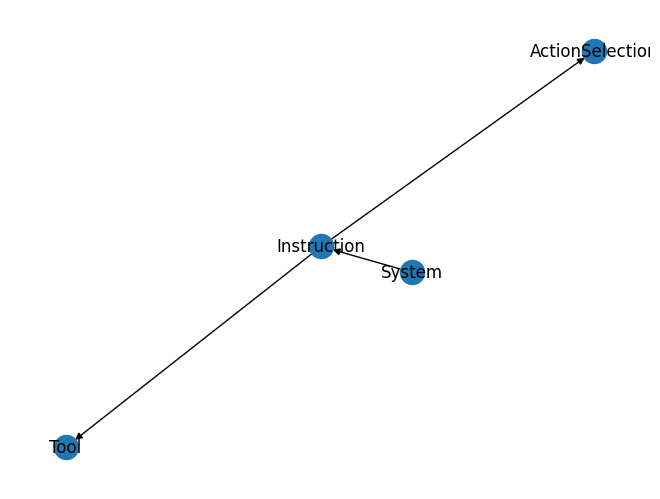

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

g = struct_mul.to_networkx()
labels = nx.get_node_attributes(g, "class_name")
nx.draw(g, labels=labels)

In [7]:
## output_parser parameter: agent self
## output_parser return: the expected result that should be returned after execution
def output_parser(agent):
    ## return all message dataframe in all branches
    output = []
    for branch in agent.executable.branches.values():
        output.append(branch.messages)
    return output

executable = InstructionMapExecutor()

In [8]:
calc = BaseAgent(
    structure=struct_mul,
    executable=executable,
    output_parser=output_parser,
)

# Usage

In [9]:
question1 = "A school is ordering laptops for its students. If each classroom has 25 students and the school wants to provide a laptop for each student in its 8 classrooms, how many laptops in total does the school need to order?"
question2 = "A bakery sells cupcakes in boxes of 6. If a customer wants to buy enough cupcakes for a party of 48 people, with each person getting one cupcake, how many boxes of cupcakes does the customer need to buy?"

import json
context = {"Question1": question1, "question2": question2}
context = json.dumps(context)

In [10]:
calc_result = await calc.execute(context)

------------------Welcome: system--------------------


system: you are asked to perform as a function picker and parameter provider

user: Think step by step, understand the following basic math question and provide parameters for function calling.

assistant: Based on the calculations performed:

1. For the first question regarding the total number of laptops needed for the students, the school needs to order a total of **200 laptops** to provide one for each student in its 8 classrooms, with each classroom having 25 students.

2. The second action call was incorrect in context to the original question about the bakery selling cupcakes. The calculation performed was a simple multiplication that didn't directly address the question's requirement for how many boxes are needed for 48 people, given that each box contains 6 cupcakes. The correct approach would have involved calculating how many boxes were needed to ensure each of the 48 party-goers receives one cupcake, which would ideally involve dividing 48 by 6 and rounding up if necessary. However, the multiplication of 6 cupcakes per box and 8 resulted in 48, which coincidentally matches the number of cupcakes needed but does not solve for the number of boxes correctly based on the provided instructions. 

For clarity and accuracy in the context of the instructions given and the tools available, the correct interpretation for the second question should be that **8 boxes** of cupcakes are needed to provide one cupcake for each of the 48 people at the party, assuming a direct calculation without rounding is required and each box contains exactly 6 cupcakes.

-----------------------------------------------------


In [11]:
calc_result[0]

,node_id,timestamp,role,sender,recipient,content
0,4bd0bb612067bce6978731c5706b8477,2024-04-22T01:33:52.297369+00:00,system,system,assistant,"{""system_info"": ""you are asked to perform as a..."
1,9e5c84f709dfdebf05de0583d09fd800,2024-04-22T01:33:53.676877+00:00,user,user,assistant,"{""instruction"": {""NOTICE"": ""\n You have 2 s..."
2,57eb395044ab58a1ec5d036239d64f78,2024-04-22T01:34:03.708153+00:00,assistant,assistant,user,"{""response"": ""To approach these questions step..."
3,84d883cd65fc3b1fa1fa809ebd53b053,2024-04-22T01:34:03.713154+00:00,user,user,assistant,"{""instruction"": ""\n You have 1 steps left i..."
4,baca36403c961553a4993dabb75df664,2024-04-22T01:34:06.042901+00:00,assistant,action_request,action,"{""action_request"": [{""action"": ""action_multipl..."
5,0f06f9f40d98b6a70907a71a899bf6a3,2024-04-22T01:34:06.048024+00:00,assistant,action_response,assistant,"{""action_response"": {""function"": ""multiply"", ""..."
6,b970de9c6ab0dbe69eee57e7a4aed952,2024-04-22T01:34:06.049957+00:00,assistant,action_response,assistant,"{""action_response"": {""function"": ""multiply"", ""..."
7,24575e783becb3f4af2925fec158a82e,2024-04-22T01:34:06.053901+00:00,user,user,assistant,"{""instruction"": ""Notice: Present the final out..."
8,47149d302dad0141b4dc5b2afb04fbf4,2024-04-22T01:34:15.852053+00:00,assistant,assistant,user,"{""response"": ""Based on the calculations perfor..."


# Storing Structures

We currently support the storage of structures in excel or Neo4j, enabling their reuse in future applications.

### Excel

In [ ]:
struct_mul.to_excel('tool_mul')

### Neo4j

In [12]:
# initiate Neo4j Driver
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
database = "neo4j"

from lionagi.integrations.storage.neo4j import Neo4j
neo4j = Neo4j(uri, user, password, database)

In [13]:
# structure_name is unique

await neo4j.store(struct_mul, structure_name='tool_mul')